In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm

from red import UNet3D
from qsmloader import QSMLoader
from torch.utils.data import DataLoader
from utils import plot_3d_medical_image
import matplotlib.pyplot as plt
from loss import quantile_regression_loss_fn
from scipy import io
from utils import continuous_dipole_kernel
import numpy as np

In [2]:
torch.cuda.init()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load simData

In [131]:

data = io.loadmat('data/Cosmos_SNR100.mat')
chi = data['chi_cosmos'] * data['mask_use']
mask = data['mask_use']

phase = np.real(np.fft.ifftn(np.fft.fftn(chi) * continuous_dipole_kernel(chi.shape))) * mask

mag = chi - chi.min()
mag = mag / mag.max()
mag = mag * mask

scale = np.pi / (2 * np.max(np.abs(phase)))
signal = mag * np.exp(1j * phase * scale)

snr = np.random.randint(99, 100, (1,))

signal = signal + ((1. / snr) * (np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape)))

phase = np.angle(signal).astype(np.float32) / scale
phase = phase * mask

p = torch.Tensor(phase.copy()).unsqueeze(0).unsqueeze(0)

phase[80, 80, 80] = 20
p2 = torch.Tensor(phase).unsqueeze(0).unsqueeze(0)

# Load Model

In [4]:
model = UNet3D(in_channels=1, out_channels=3)
model = model.to(device)

In [ ]:
rmse = []
rmse2 = []
for i in tqdm(range(1, 51)):
    model.load_state_dict(torch.load(f'./saved/model_epoch_{i}.pth', weights_only=False))
    # model = model.to(device)
    model.eval()
    with torch.inference_mode():
        out = model((p).to(device)).cpu() * mask
    gt = data['chi_cosmos'] * data['mask_use']
    pred = out[0, 1].numpy() * data['mask_use']
    m = data['mask_use'] == 1
    rmse.append(100 * np.linalg.norm(pred.ravel() - gt.ravel()) / np.linalg.norm(gt.ravel()))

    with torch.inference_mode():
        out = model((p2).to(device)).cpu() * mask
    gt = data['chi_cosmos'] * data['mask_use']
    pred = out[0, 1].numpy() * data['mask_use']
    m = data['mask_use'] == 1
    rmse2.append(100 * np.linalg.norm(pred.ravel() - gt.ravel()) / np.linalg.norm(gt.ravel()))

In [ ]:
print((np.argmin(rmse)), (np.argmin(rmse2)))
plt.figure()
plt.plot(rmse, label='normal')
plt.plot(rmse2, label='phase jump')
plt.legend()
plt.show()

In [ ]:
rmse[47], rmse2[47], rmse[np.argmin(rmse)], rmse2[np.argmin(rmse2)]

In [132]:
model.load_state_dict(torch.load('./saved/model_epoch_48.pth', weights_only=False))
model.eval()

UNet3D(
  (enc1): ConvBlock(
    (conv): Sequential(
      (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (enc2): ConvBlock(
    (conv): Sequential(
      (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): L

In [133]:
with torch.inference_mode():
    out = model((p2).to(device)).cpu() * mask

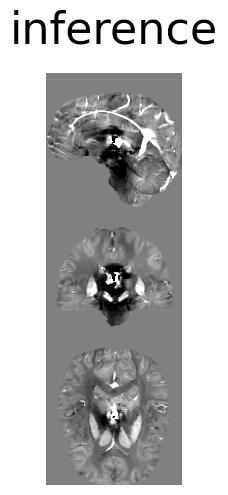

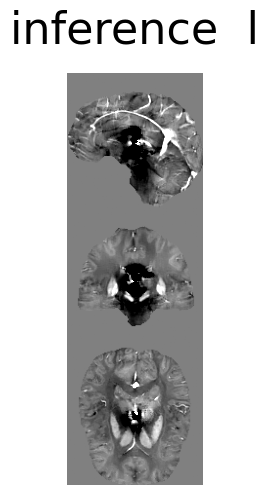

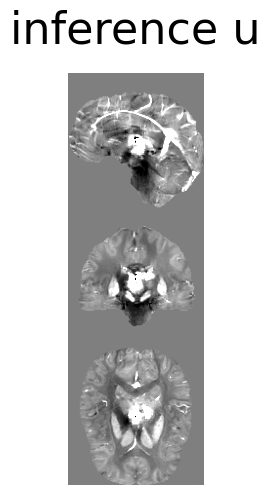

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [134]:
plot_3d_medical_image(out[0, 1], 'inference', rango=(-0.1, 0.1))
plot_3d_medical_image(out[0, 0], 'inference  l', rango=(-0.1, 0.1))
plot_3d_medical_image(out[0, 2], 'inference u', rango=(-0.1, 0.1))

In [135]:
from scipy.ndimage import affine_transform


def rotation_matrix(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])


def rotate_image(image, theta):
    # Matriz de rotación
    rot_mat = rotation_matrix(theta)

    # Calcular el centro de la imagen
    center = np.array(image.shape) / 2

    # Trasladar el origen al centro
    offset = center - np.dot(rot_mat, center)

    # Aplicar la transformación afín
    rotated_image = affine_transform(
        image, rot_mat, offset=offset, order=1  # 'order=1' aplica una interpolación bilineal
    )
    return rotated_image


def plot_3d_medical_image(image, title=None, cmap='gray', rango=None, show=True):
    """
    Plot a 3D medical image in three views: axial, coronal, and sagittal.
    
    Parameters:
    - image: 3D numpy array with shape (D, H, W)
    - title: string, optional title for the entire figure
    - cmap: string, colormap to use for the plots (default is 'gray')
    """
    if rango is None:
        rango = (image.min(), image.max())

    D, H, W = image.shape

    im1 = image[D // 2, :, :]
    im1 = rotate_image(im1, np.radians(-90))

    im2 = image[:, H // 2, :]
    im2 = rotate_image(im2, np.radians(-90))

    im3 = image[:, :, W // 2]
    im3 = rotate_image(im3, np.radians(90))

    xx, yy = np.where(im1 != 0)
    im1 = im1[np.min(xx):np.max(xx), :]

    xx, yy = np.where(im2 != 0)
    im2 = im2[np.min(xx):np.max(xx), :]

    xx, yy = np.where(im3 != 0)
    im3 = im3[np.min(xx):np.max(xx), :]

    im = np.concatenate([im1, im2, im3], axis=0)

    if show:
        # Create a figure with three subplots
        fig, ax = plt.subplots(1, 1, figsize=(15, 5))
        # Sagittal view (side)
        ax.imshow(im, cmap=cmap, aspect='equal', vmin=rango[0], vmax=rango[1])
        # ax3.set_title('Sagittal View')
        ax.axis('off')
        if title:
            fig.suptitle(title, fontsize=32)
        plt.tight_layout()
        plt.show()
    return im


In [91]:
np.where(out[0, 1] != 0)

(array([ 20,  20,  20, ..., 140, 140, 140], dtype=int64),
 array([ 94,  94,  94, ..., 103, 103, 103], dtype=int64),
 array([61, 62, 63, ..., 60, 61, 62], dtype=int64))

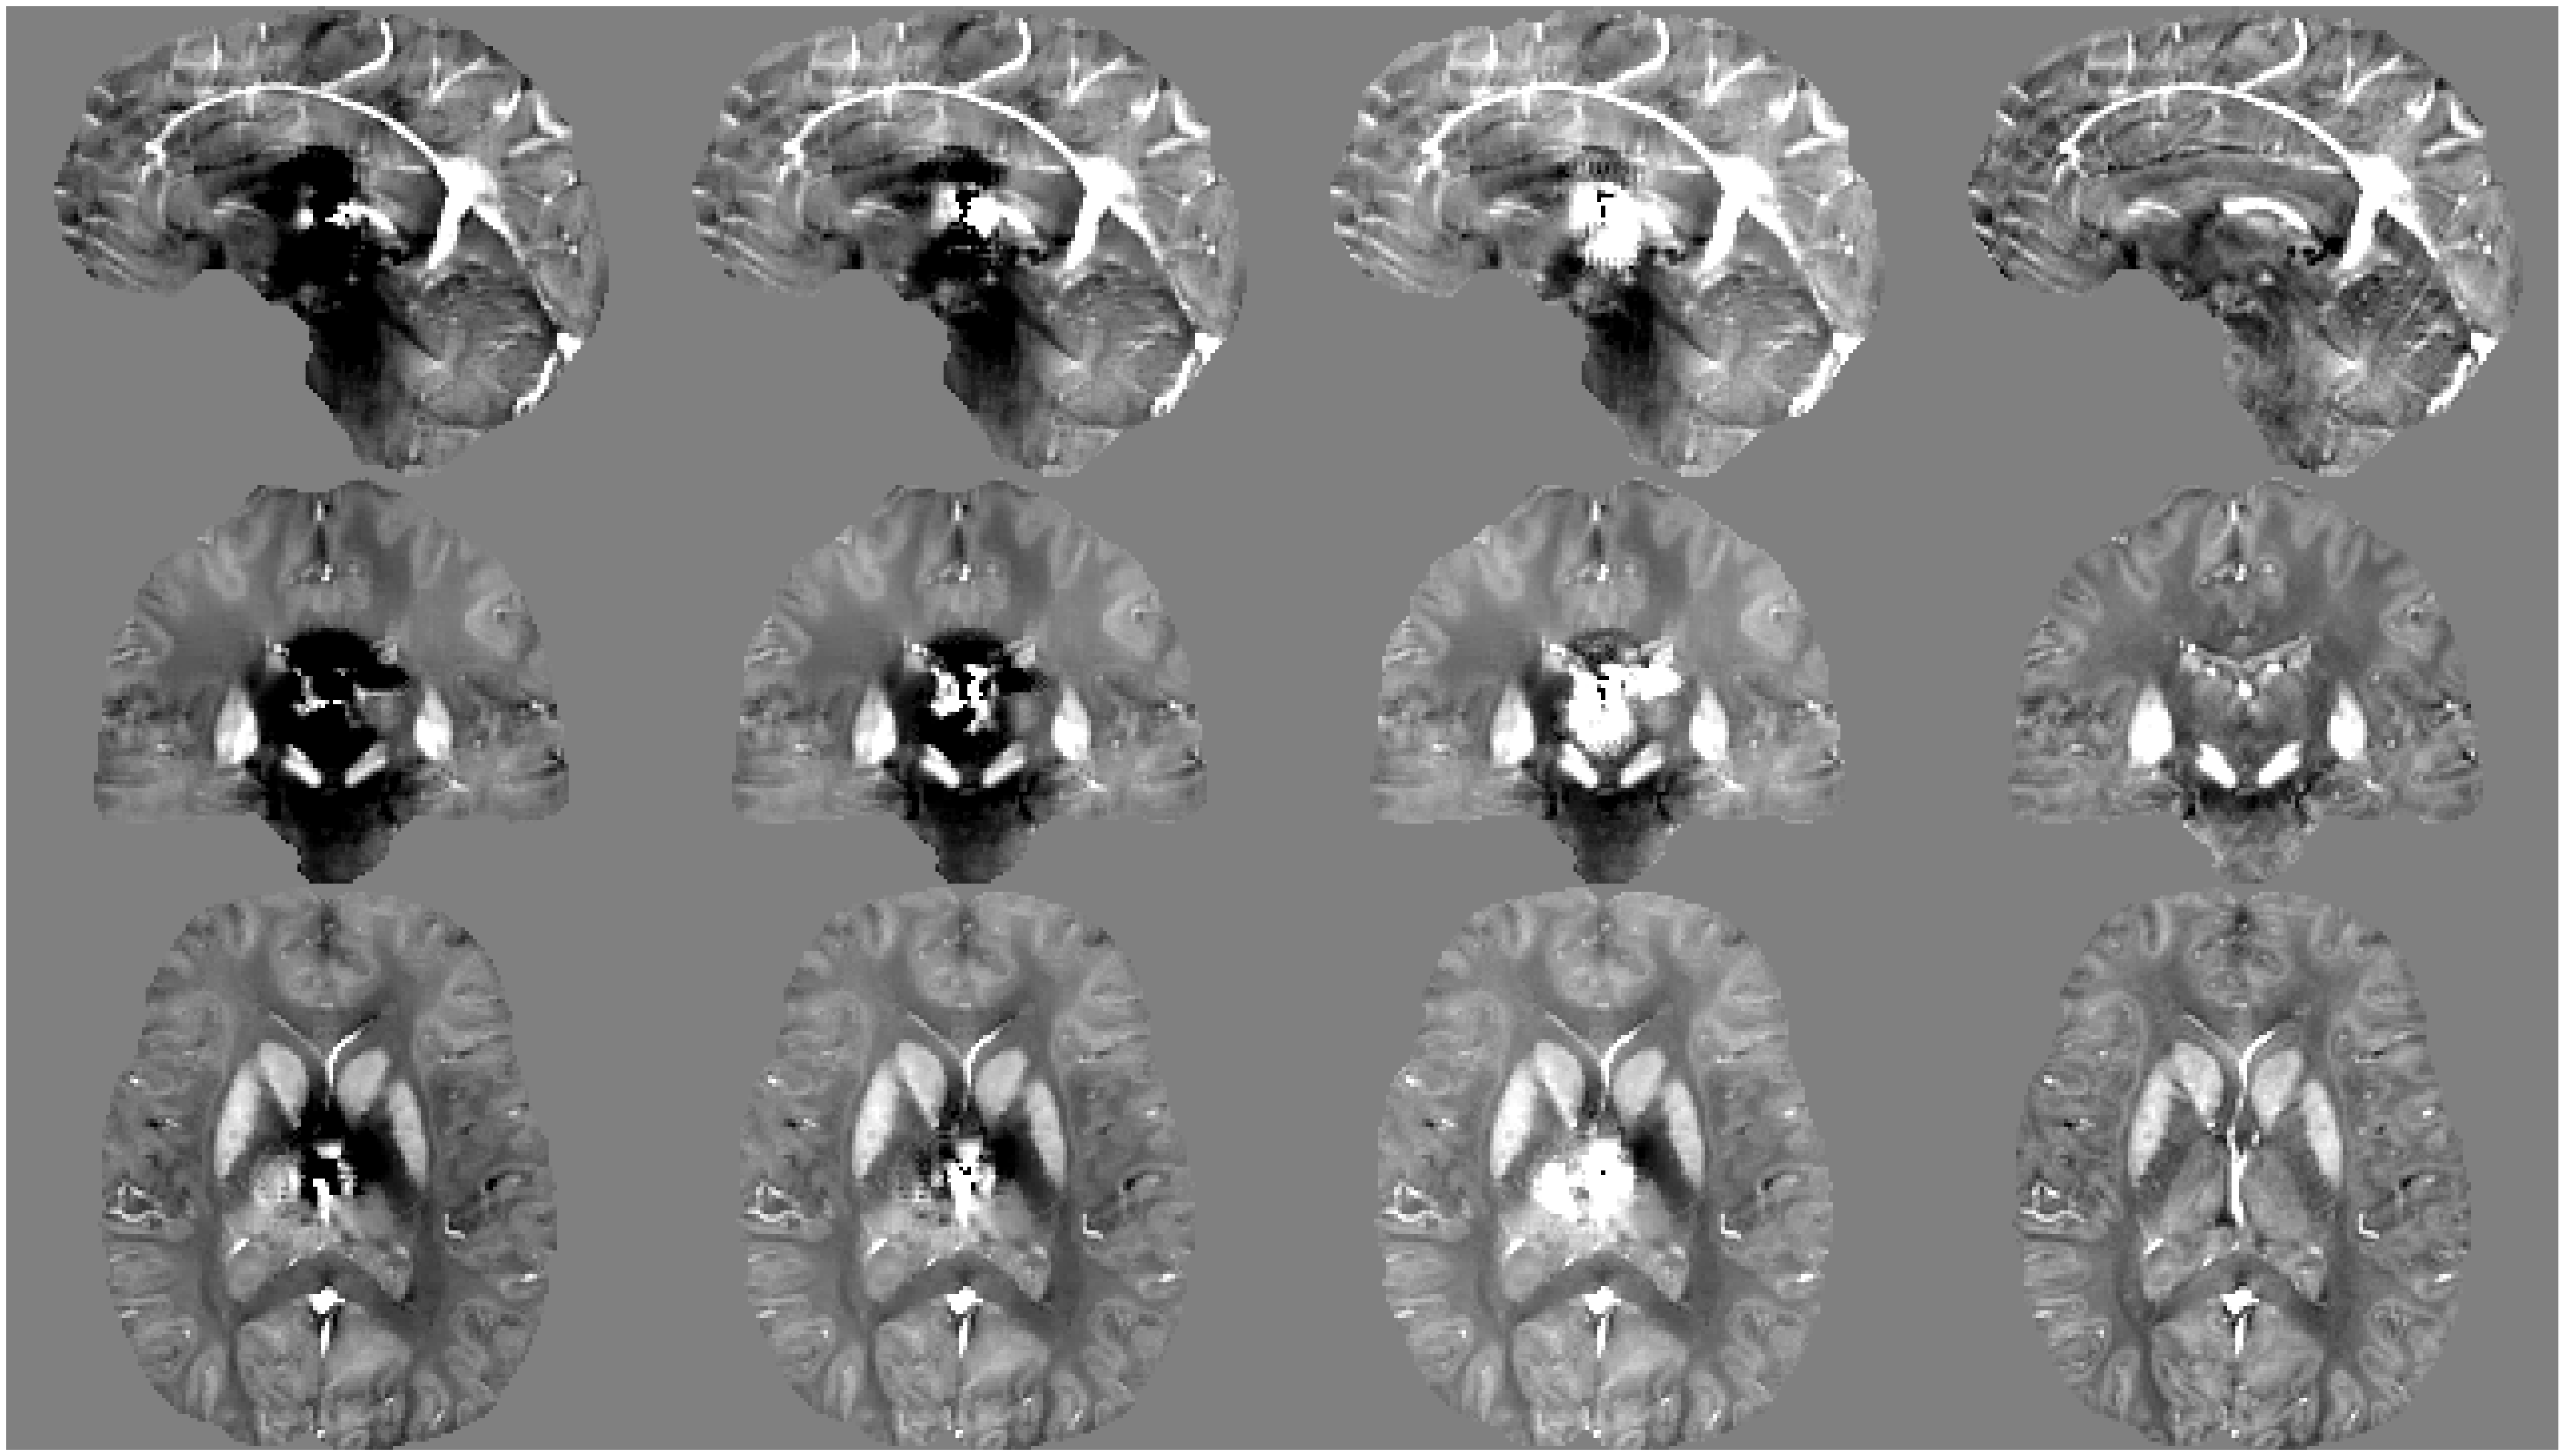

In [136]:
im1 = plot_3d_medical_image(out[0, 1], 'inference', rango=(-0.1, 0.1), show=False)
im2 = plot_3d_medical_image(out[0, 0], 'inference  lo', rango=(-0.1, 0.1), show=False)
im3 = plot_3d_medical_image(out[0, 2], 'inference ip', rango=(-0.1, 0.1), show=False)
im4 = plot_3d_medical_image(data['chi_cosmos'] * data['mask_use'], 'inference ip', rango=(-0.1, 0.1), show=False)

im = np.concatenate([im2, im1, im3, im4], axis=1)
sh = np.asarray((im.shape[1], im.shape[0]))
sh = 30 * sh / sh[1]
plt.figure(figsize=sh)
plt.imshow(im, cmap='gray', aspect='equal', vmin=-0.1, vmax=0.1)
plt.axis('off')
plt.show()

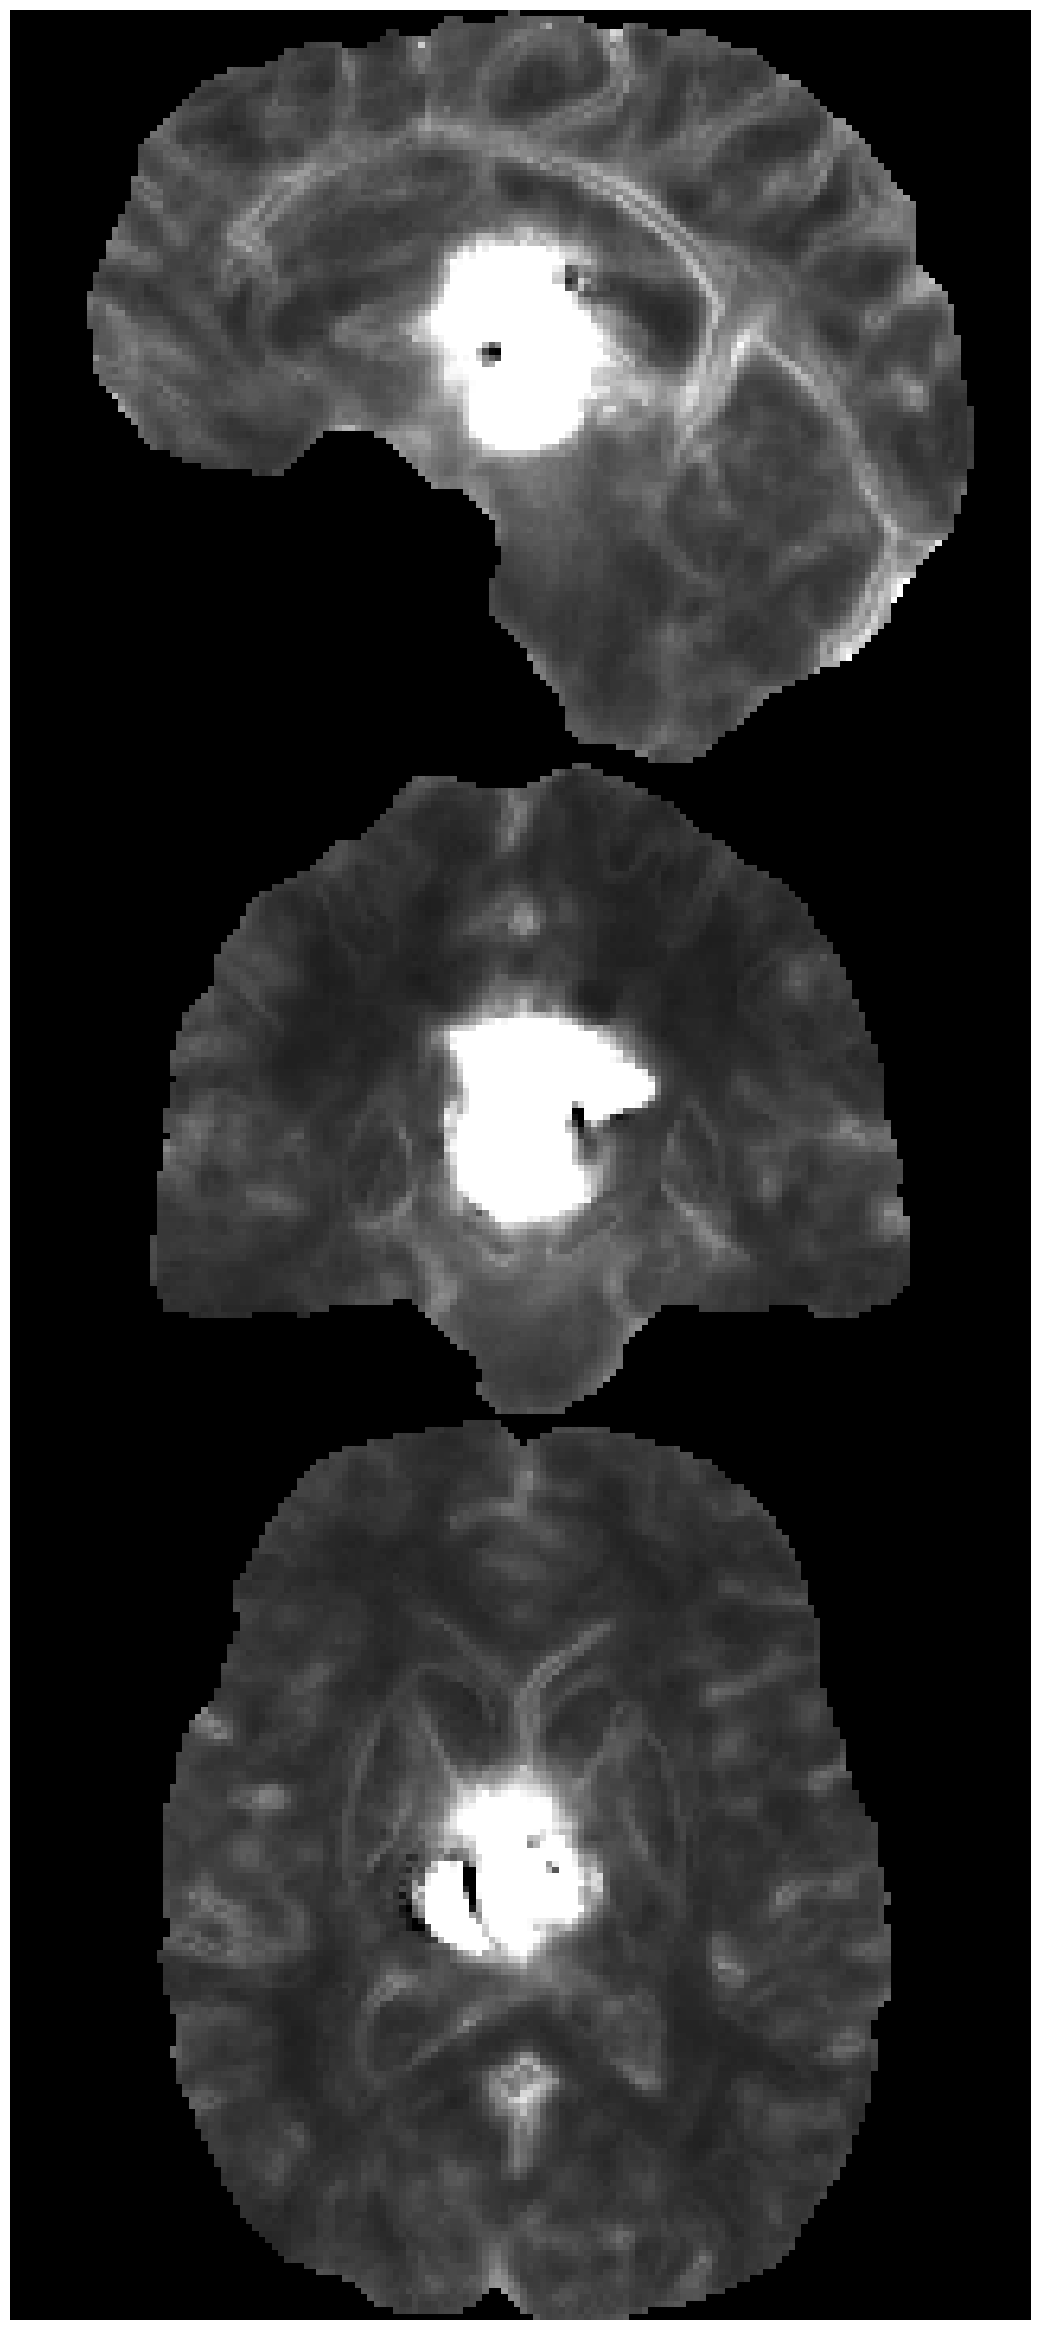

In [137]:
pred_l = out[0, 0].numpy() * data['mask_use']
pred_u = out[0, 2].numpy() * data['mask_use']
pred_ul = pred_u - pred_l
im = plot_3d_medical_image(pred_ul, 'inference ip', rango=(-0.1, 0.1), show=False)

sh = np.asarray((im.shape[1], im.shape[0]))
sh = 30 * sh / sh[1]
plt.figure(figsize=sh)
plt.imshow(im, cmap='gray', aspect='equal', vmin=-0., vmax=0.1)
plt.axis('off')
plt.show()

In [138]:
gt = data['chi_cosmos'] * data['mask_use']
pred = out[0, 1].numpy() * data['mask_use']
m = data['mask_use'] == 1
print(100 * np.linalg.norm(pred.ravel() - gt.ravel()) / np.linalg.norm(gt.ravel()))

107.36083040939181


In [139]:
gt = data['chi_cosmos'] * data['mask_use']
pred = out[0, 0].numpy() * data['mask_use']
m = data['mask_use'] == 1
print(100 * np.linalg.norm(pred.ravel() - gt.ravel()) / np.linalg.norm(gt.ravel()))

135.16166556073688


In [140]:
gt = data['chi_cosmos'] * data['mask_use']
pred = out[0, 2].numpy() * data['mask_use']
m = data['mask_use'] == 1
print(100 * np.linalg.norm(pred.ravel() - gt.ravel()) / np.linalg.norm(gt.ravel()))

202.52354484494901


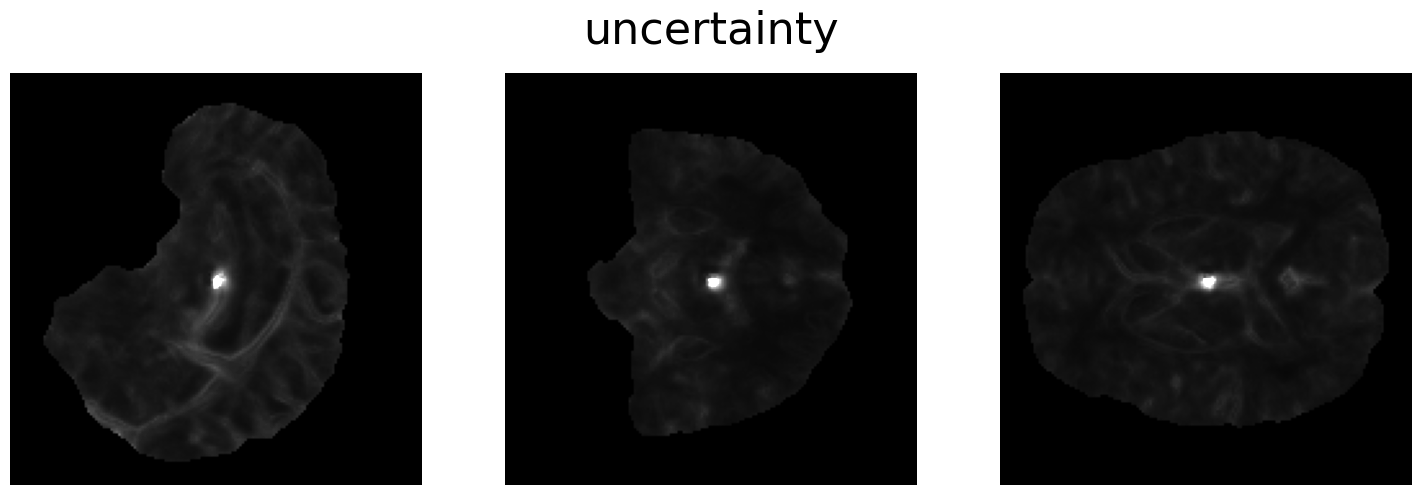

In [78]:
pred_l = out[0, 0].numpy() * data['mask_use']
pred_u = out[0, 2].numpy() * data['mask_use']
pred_ul = pred_u - pred_l
# print(pred_ul[m].min(), pred_ul[m].mean(), pred_ul[m].max())
plot_3d_medical_image(pred_ul, 'uncertainty', rango=(0, 0.3))


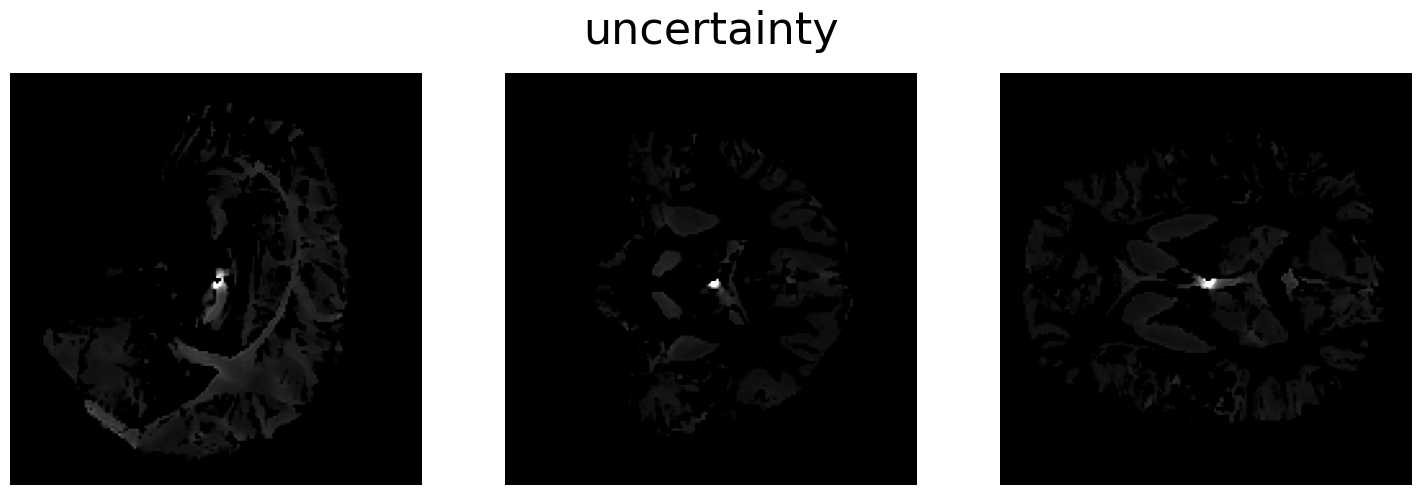

In [10]:
pred_l = out[0, 0].numpy() * data['mask_use']
pred_u = out[0, 2].numpy() * data['mask_use']
pred_ul = np.abs(pred_u) - np.abs(pred_l)
# print(pred_ul[m].min(), pred_ul[m].mean(), pred_ul[m].max())
plot_3d_medical_image(pred_ul, 'uncertainty', rango=(0, 0.3))


In [ ]:
ds_calib = QSMLoader(list(range(5_00)), root="./calib/", train=False)
calib_dl = DataLoader(ds_calib, batch_size=16, shuffle=False)

In [ ]:
preds = []
gts = []
masks = []
for phase, gt, mask, phase_sr in tqdm(calib_dl):
    with torch.inference_mode():
        model.eval()
        out = model((phase).to(device)).cpu() * mask
    preds.append(out)
    gts.append(gt * mask)
    masks.append(mask)
preds = torch.concat(preds, 0)
gts = torch.concat(gts, 0)
masks = torch.concat(masks, 0)
preds.shape, gts.shape, masks.shape

In [ ]:
def is_in(preds, gts, masks, lambd=1):
    lo = preds[:, 1] - torch.abs(preds[:, 0]) * lambd
    up = preds[:, 1] + torch.abs(preds[:, 2]) * lambd
    r = (gts[:, 0] > lo) & (gts[:, 0] < up)
    r = r.flatten(1)
    m = masks.flatten(1)
    r = torch.sum(r, 1) / torch.sum(m, 1)
    return r

In [ ]:
is_in(preds, gts, masks, 1)

In [ ]:
preds.__class__

In [ ]:
lambd = 1000000000
lo = preds[:, 1] - preds[:, 0] * lambd
up = preds[:, 1] + preds[:, 2] * lambd
print(lo.shape, up.shape, preds[:, 1].shape)
r = (preds[:, 1] > lo) & (preds[:, 1] < up)
r = r.flatten(1)
r = torch.sum(r, 1)  #/ r.shape[1]

In [ ]:
r

In [ ]:
64 ** 3

In [ ]:
up.mean()

In [ ]:
preds[:, 0].mean(), preds[:, 1].mean(), preds[:, 2].mean()

# DAta inVIVO

In [161]:

def plot_3d_medical_image(image, title=None, cmap='gray', rango=None, show=True):
    """
    Plot a 3D medical image in three views: axial, coronal, and sagittal.
    
    Parameters:
    - image: 3D numpy array with shape (D, H, W)
    - title: string, optional title for the entire figure
    - cmap: string, colormap to use for the plots (default is 'gray')
    """
    if rango is None:
        rango = (image.min(), image.max())

    D, H, W = image.shape

    im1 = image[D // 2, :, :]
    im1 = rotate_image(im1, np.radians(-90))

    im2 = image[:, H // 2, :]
    im2 = rotate_image(im2, np.radians(-90))

    im3 = image[:, :, W // 2]
    im3 = rotate_image(im3, np.radians(-90))


    xx1, yy1 = np.where(im1 != 0)
    xx2, yy2 = np.where(im2 != 0)
    xx3, yy3 = np.where(im3 != 0)
    xx = np.concatenate([xx1, xx2, xx3])
    yy = np.concatenate([yy1, yy2, yy3])
    
    im1 = im1[np.min(xx1):np.max(xx1), np.min(yy):np.max(yy)]
    im2 = im2[np.min(xx2):np.max(xx2), np.min(yy):np.max(yy)]
    im3 = im3[np.min(xx3):np.max(xx3), np.min(yy):np.max(yy)]
    
    

    im = np.concatenate([im1, im2, im3], axis=0)

    if show:
        # Create a figure with three subplots
        fig, ax = plt.subplots(1, 1, figsize=(15, 5))
        # Sagittal view (side)
        ax.imshow(im, cmap=cmap, aspect='equal', vmin=rango[0], vmax=rango[1])
        # ax3.set_title('Sagittal View')
        ax.axis('off')
        if title:
            fig.suptitle(title, fontsize=32)
        plt.tight_layout()
        plt.show()
    return im


In [159]:
data = io.loadmat('./data/data_invido_2.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'mask2', 'phase_use2'])

In [143]:
invivo_phase = data['phase_use2'] * data['mask2']
invivo_mask = data['mask2']

pad = 13
aux = np.zeros((256, 256, 128))
aux[pad:-pad, pad:-pad, :] = invivo_phase
invivo_phase = aux

aux = np.zeros((256, 256, 128))
aux[pad:-pad, pad:-pad, :] = invivo_mask
invivo_mask = aux

invivo_phase = torch.Tensor(invivo_phase.copy()).unsqueeze(0).unsqueeze(0)
invivo_mask = torch.Tensor(invivo_mask.copy()).unsqueeze(0).unsqueeze(0)
invivo_phase.shape, invivo_mask.shape


(torch.Size([1, 1, 256, 256, 128]), torch.Size([1, 1, 256, 256, 128]))

In [144]:
with torch.inference_mode():
    out = model((invivo_phase).to(device)).cpu() * invivo_mask

In [145]:
out2 = torch.zeros((1,3, 256, 256, 256))
out2[:, :, :, :, 64:-64] = out

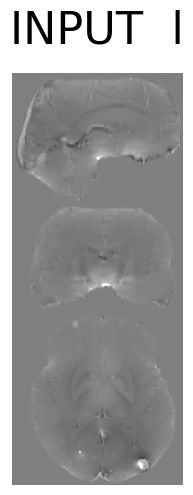

In [165]:
aux = torch.zeros((1,1, 256, 256, 256))
aux[:, :, :, :, 64:-64] = invivo_phase
im0 = plot_3d_medical_image(aux[0, 0], 'INPUT  l', rango=(-0.3, 0.3), show=True)


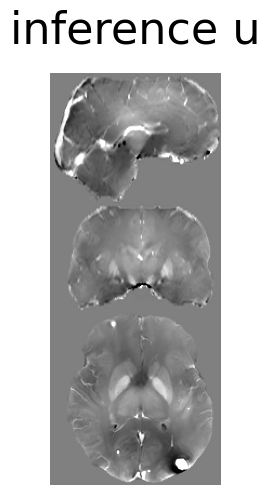

In [166]:
im1 = plot_3d_medical_image(out2[0, 1], 'inference', rango=(-0.3, 0.3), show=False)
im2 = plot_3d_medical_image(out2[0, 0], 'inference  l', rango=(-0.3, 0.3), show=False)
im3 = plot_3d_medical_image(out2[0, 2], 'inference u', rango=(-0.3, 0.3), show=True)

In [167]:
pred_l = out2[0, 0].numpy()
pred_u = out2[0, 2].numpy()
pred_ul = pred_u - pred_l
print(pred_ul.min(), pred_ul.max())
im4 = plot_3d_medical_image(np.abs(pred_ul), 'uncertainty', rango=(0, 0.2), show=False)


-0.07628062 1.2311925


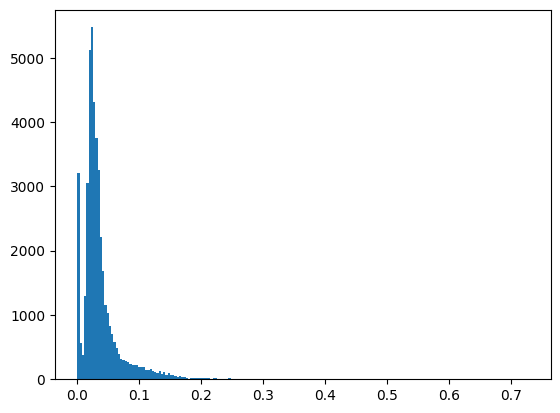

In [149]:
plt.figure()
plt.hist(im4[im4!=0], bins=200)
plt.show()

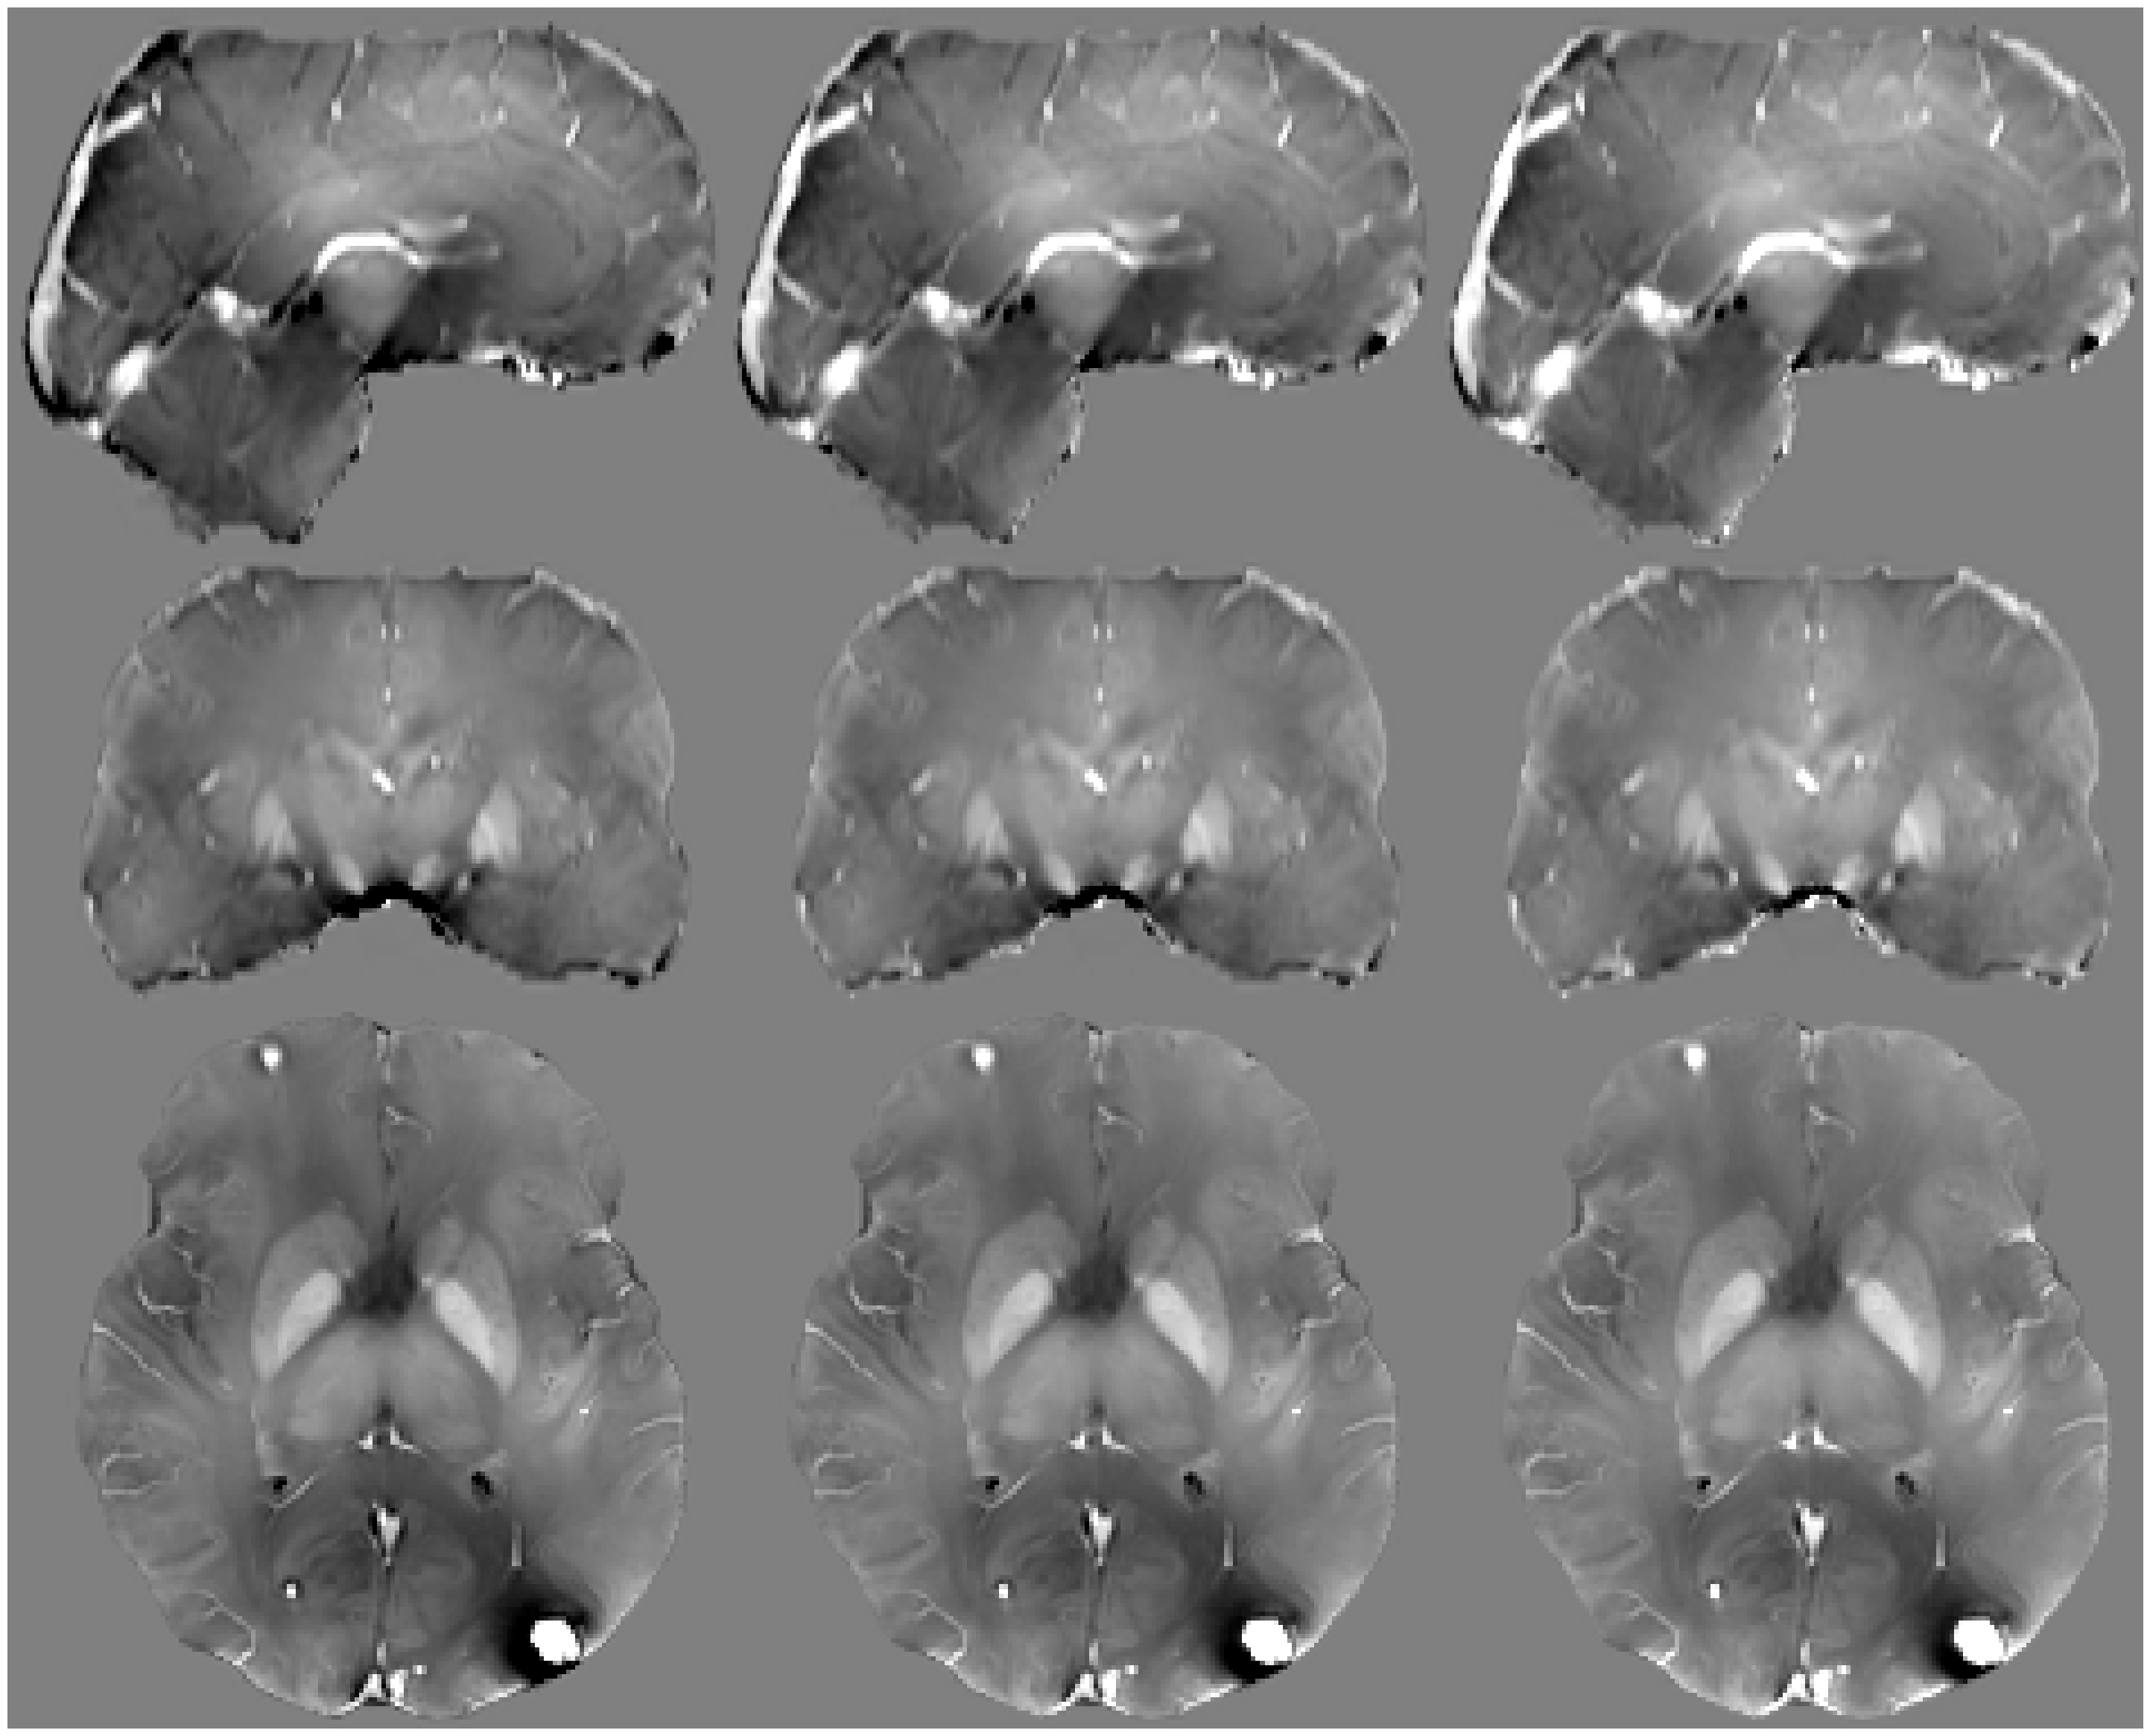

In [168]:
im = np.concatenate([im2, im1, im3], axis=1)
sh = np.asarray((im.shape[1], im.shape[0]))
sh = 30 * sh / sh[1]
plt.figure(figsize=sh)
plt.imshow(im, cmap='gray', aspect='equal', vmin=-0.3, vmax=0.3)
plt.axis('off')
plt.show()

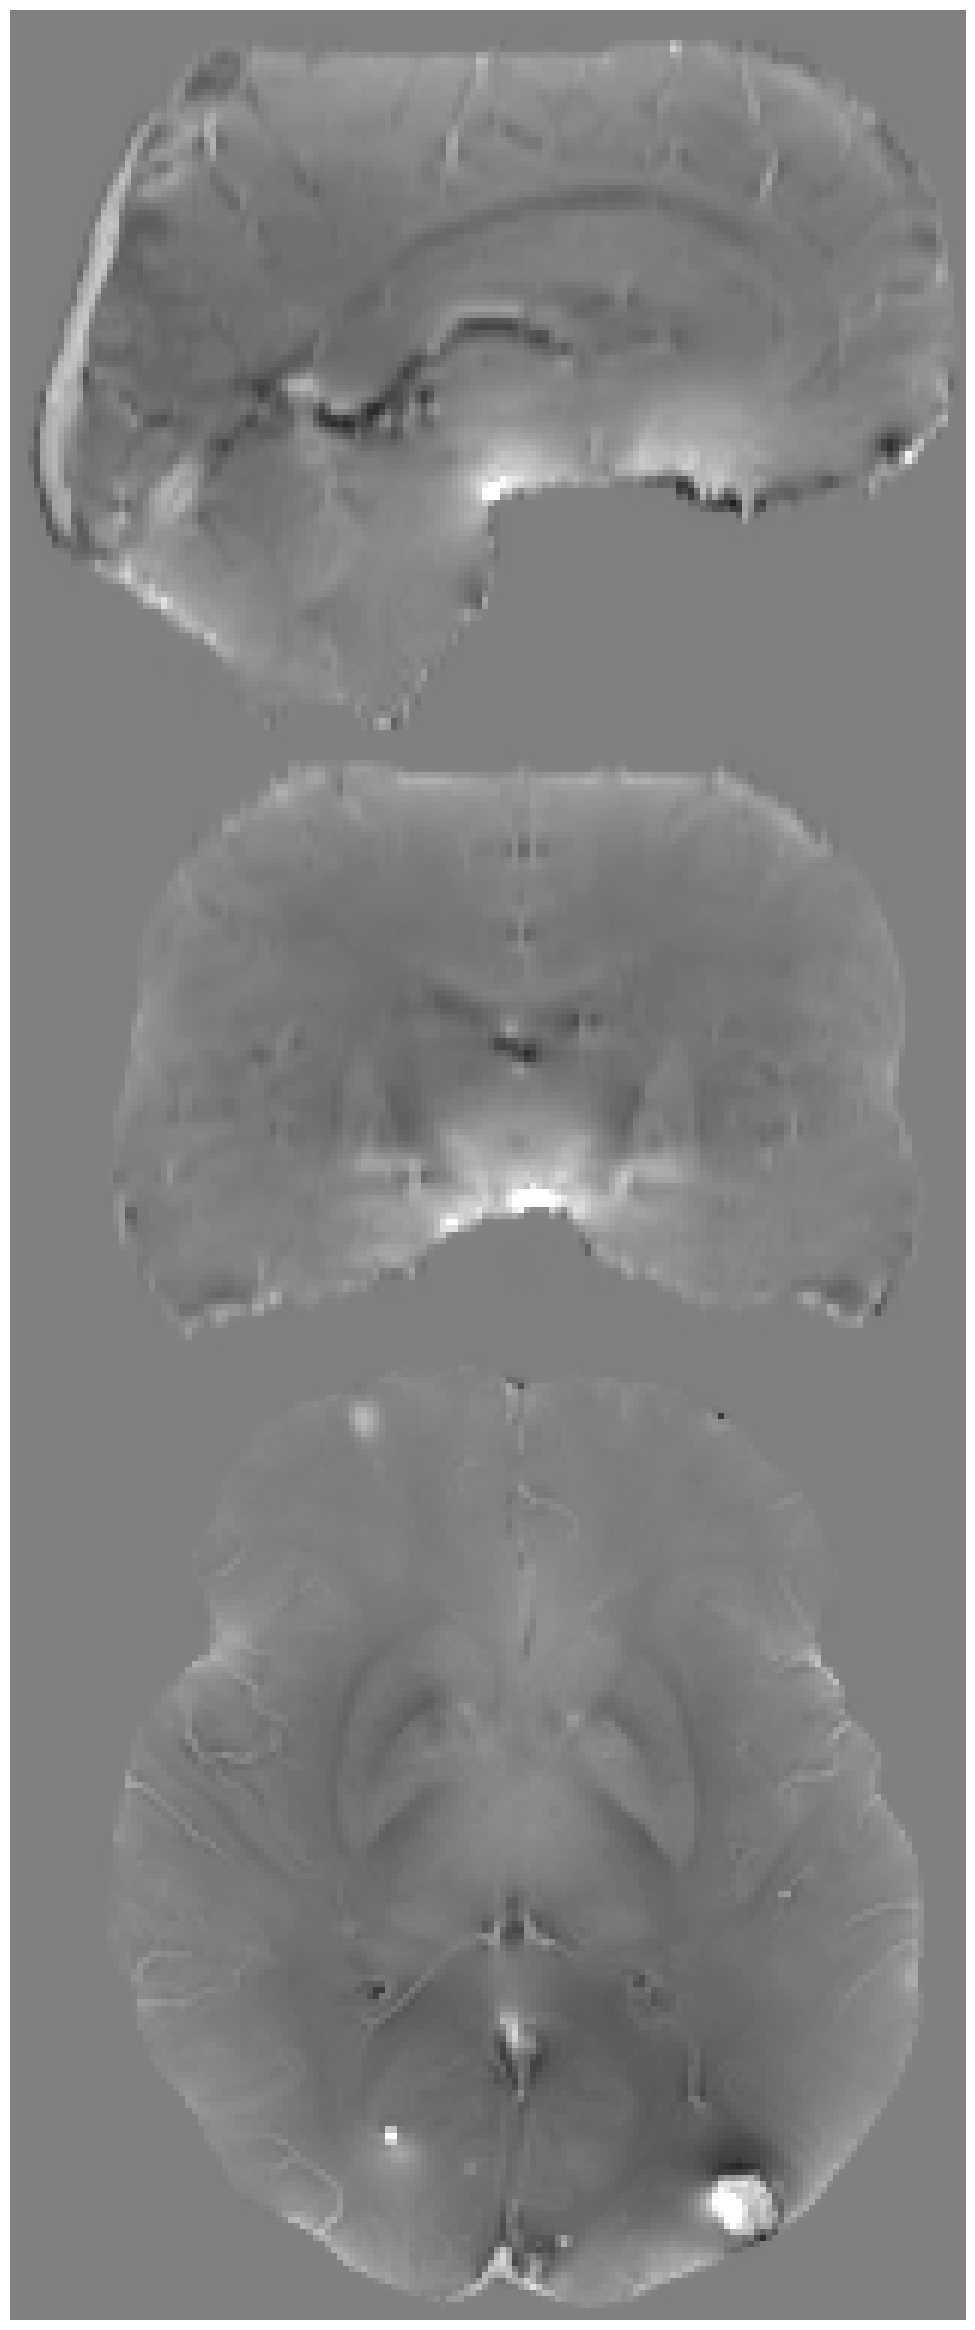

In [175]:
im = im0
sh = np.asarray((im.shape[1], im.shape[0]))
sh = 30 * sh / sh[1]
plt.figure(figsize=sh)
plt.imshow(im, cmap='gray', aspect='equal', vmin=-0.2, vmax=0.2)
plt.axis('off')
plt.show()

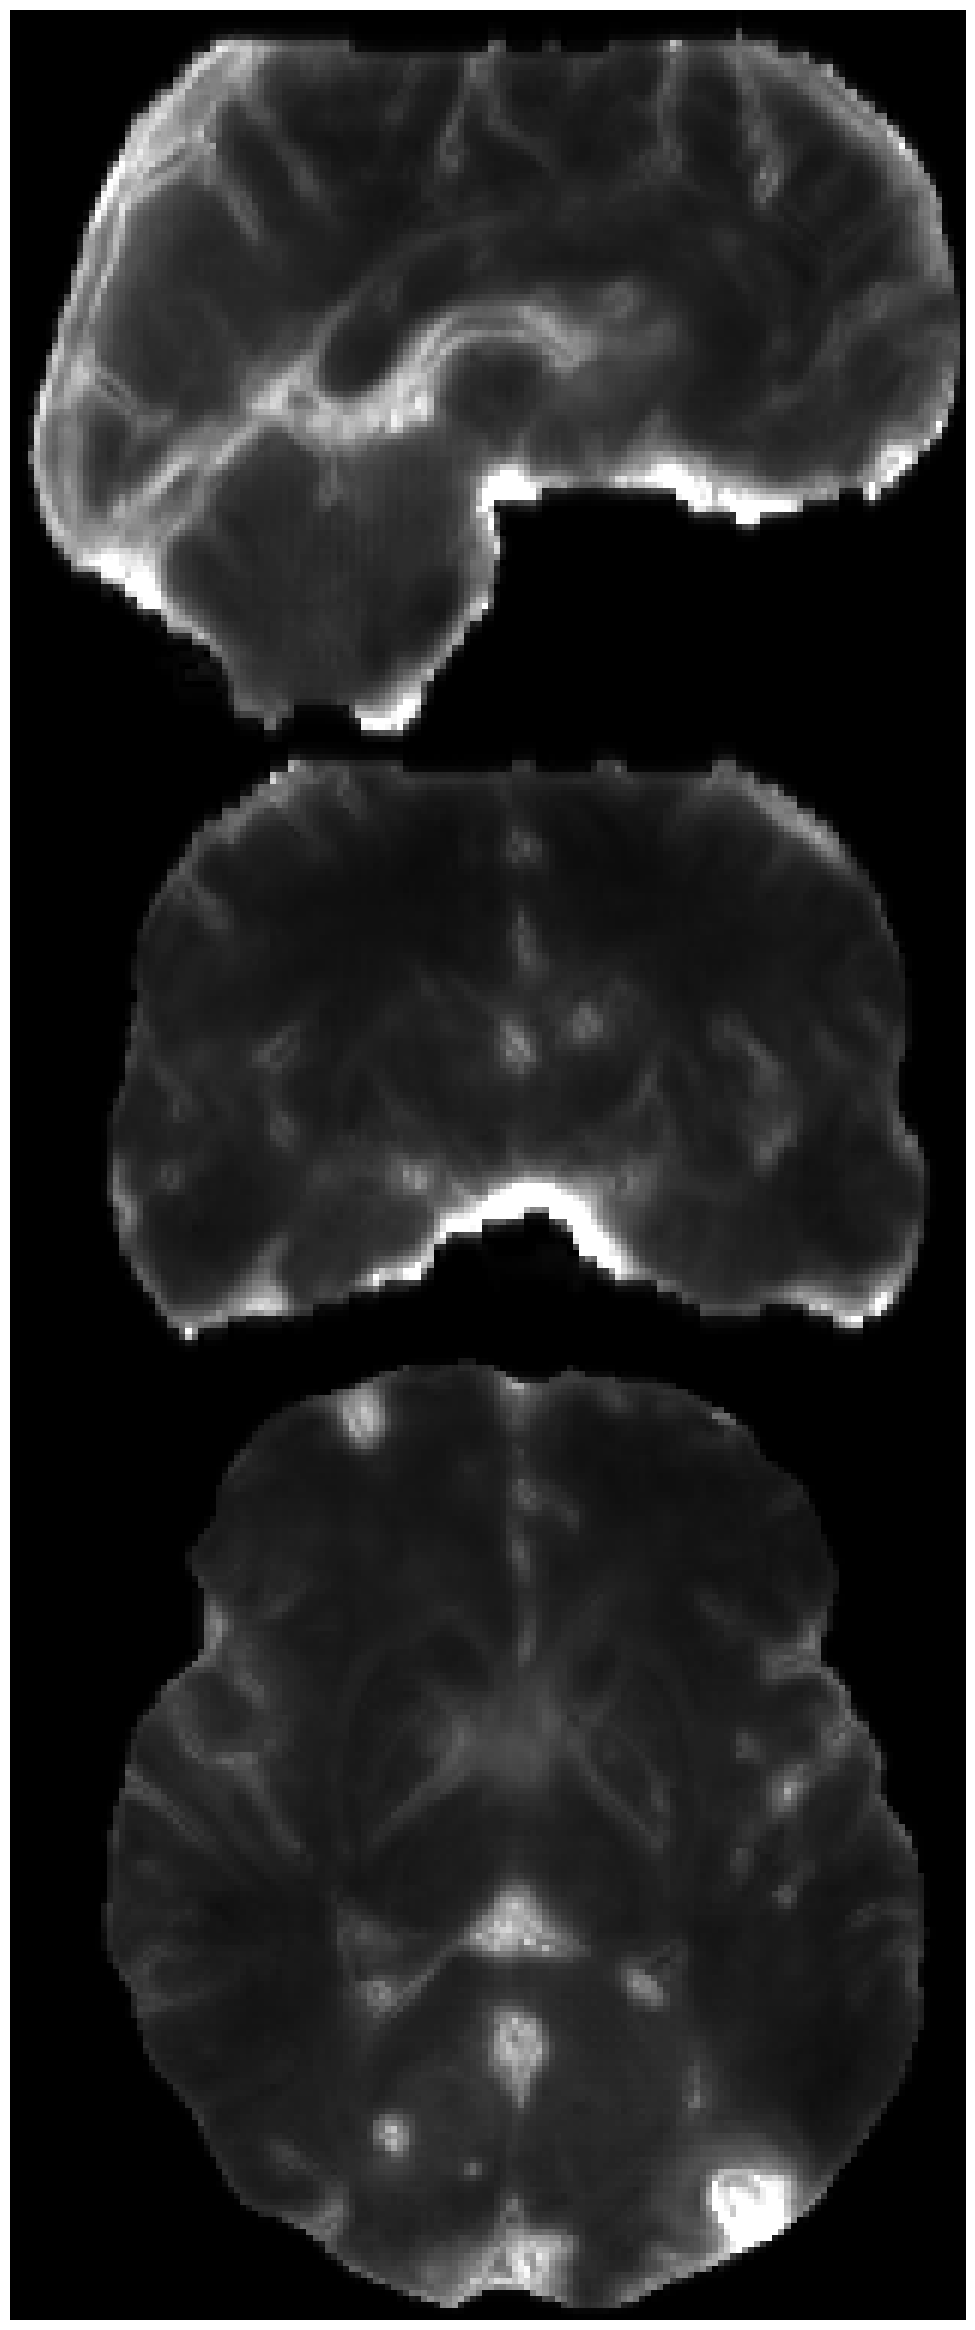

In [174]:
im = im4
sh = np.asarray((im.shape[1], im.shape[0]))
sh = 30 * sh / sh[1]
plt.figure(figsize=sh)
plt.imshow(im, cmap='gray', aspect='equal', vmin=0, vmax=0.2)
plt.axis('off')
plt.show()

In [4]:
ds_train = QSMLoader(list(range(500, 66_182)), train=True)
train_dl = DataLoader(ds_train, batch_size=1, shuffle=True)

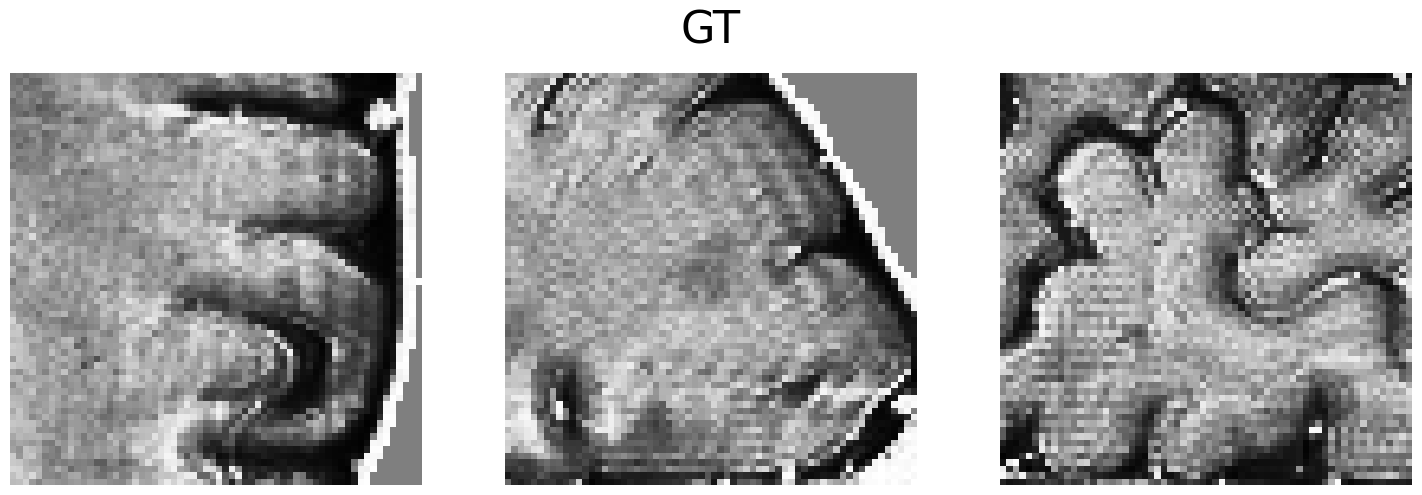

In [8]:
for phase, gt, mask, phase_sr in train_dl:
    plot_3d_medical_image(gt[0, 0], 'GT', )
    break
